In [1]:
# Setup code for later usage
from MinervaBloom import CountingBloomFilter, BloomFilter, Shakespeare

%matplotlib inline


# Indexing Techniques and Data Structures.

After learning about hashing functions and techniques, we will be exploring an implementation of such techniques called bloom filters. Firstly we will briefly discuss the [standard bloom filter](https://en.wikipedia.org/wiki/Bloom_filter), then improve upon it using [counting bloom filters](https://en.wikipedia.org/wiki/Counting_Bloom_filter).

## Standard Bloom filters

According to [Wikipedia](https://www.wikipedia.org) a [bloom filter](https://en.wikipedia.org/wiki/Bloom_filter) is "a space-efficient probabilistic data structure" conceived by [Burton Howard Bloom](https://en.wikipedia.org/wiki/Burton_Howard_Bloom) in 1970 that "tests whether an element is a member of a set". ([Bloom Filters - Geeks for Geeks][geeksforgeeks]

James Graham, an engineer at Medium, mentions that they are a quick way of "answering a YES/NO question". Although  in programming, we always have to work with _trade-offs_. They will "very rarely say YES when the answer is NO, but they will never say NO when the answer is actually YES".([What are Bloom filters?][medium]). Since they are probabilistic the more items we add into a bloom filter the higher the chance of getting a _false positive_.

Unlike a normal hash table it is an array of $m$ bits, initiated with all zeros, and requires $k$ hash functions to insert an element. The hash functions reveal the slots that are flipped from 0 to 1 when _adding_ an element.

![Empty bloom filter](./images/empty_bloom.png "An empty bloom filter")

![Inserting elements into a bloom filter](./images/insert_bloom.png "Inserting elements into a bloom filter")

To check if an element has been inserted into the array, all the hash functions of the element should point to slots containing a 1. However, when we _query_ for an element that has not been inserted yet, some of the slots pointed to by the hash functions will contain a zero.

![Checking for a non-inserted element](./images/check_bloom.png "Checking for an element that has not been inserted")

Occasionally, we might get a false positive whereby all the hashing functions produce a collision. It is rare for all of them to, but it happens. Adding more hash functions reduces the false error rate $\epsilon$, but it doesn't make it impossible. The more elements we add the more the bloom filter gets filled up as the error rate increases until all the bits are flipped to 1 then the error rate is 100%.

![Getting a false positive](./images/false_positive.png "Getting a false positive")

The characteristics we have outlined above on bloom filters makes it impossible to get the actual elements added. Bloom filters can only answer "Do you have _this_?", but can never answer "What do you have?". Therefore, standard bloom filters do not support deletion of elements because the bits might be shared. Although deletion is simple, just flipping a single bit of the element's hash values to 0. We don't do it because it leads to deletion of other unintended elements.

### Useful equations

Although we will not theoretically or experimentally prove the following relationships, they are important to help us model our bloom filters. The equations are originally from [Geeks For Geeks][geeksforgeeks].

#### False Probability Rate

The FPR is given by the following formula:
$$\epsilon = (1 - [1 - \frac{1}{m}]^{kn})^{k}$$
$\epsilon$, is the false error rate while $m$ is the size of the bit array, $n$, the number of expected elements to be inserted, and $k$ the number hash functions.

[medium]: https://blog.medium.com/what-are-bloom-filters-1ec2a50c68ff

[geeksforgeeks]: https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/)


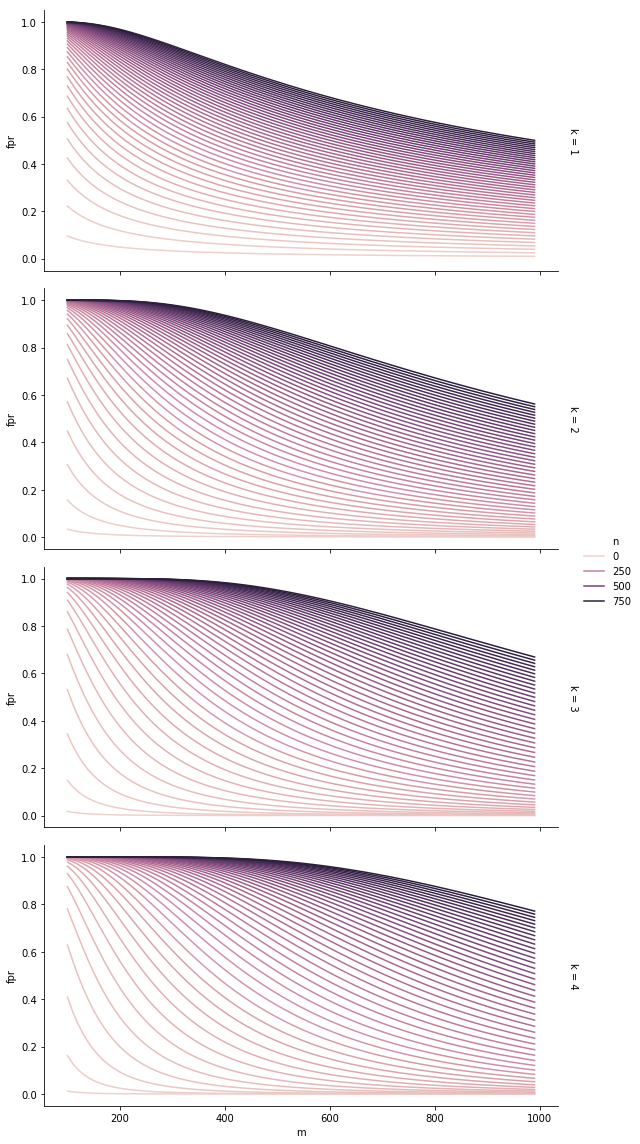

In [2]:
BloomFilter.probability_rate()

As we can see from the plot the higher the value of $k$ the faster $\epsilon$ grows gets when $n$ increases. However, when we look closely at the theoretical plots, we notice that also, as $k$ increases, for smaller values of $n$, $\epsilon$ reduces. Such a trend continues up-to a certain value of $k$ then it goes back to the normal trend of increasing $\epsilon$ instead of reducing.

#### Size of bit array

When we know the expected number of elements, $n$, and the desired error rate, $\epsilon$, then the size of the bit array is calculated as follows:
$$m = - \frac{nln\epsilon}{(ln2)^{2}}$$


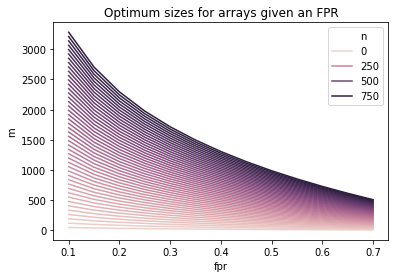

In [3]:
BloomFilter.bit_array_size()

As we can see from the plot, the higher the $\epsilon$ we want to maintain the lower the value of $m$ as $n$ increases. Optimally, we want a low $\epsilon$ but we also want to be space efficient since the low $\epsilon$ levels comes with a high value of $m$ especially as $n$ grows.

#### Number of hash functions

The optimum number of hash functions is given by:
$$k = \frac{m}{n}ln2$$

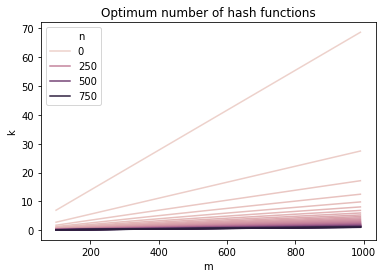

In [4]:
BloomFilter.hash_functions()

We are now confident in what we were observing earlier that when we have a smaller $n$, the more $k$ functions we need, however, when $n$ gets larger, the fewer the better. However, it is not entirely correct since we assume independence of values of bits.

**Time complexity:** The two operations that a bloom filter carries out are addition, and querying. Both of which take constant time. Therefore, we can represent them as $O(1)$, however, the number of hash functions affects the constant. The more we use the larger the constant value.

### Useful cases

1. James Graham, our engineer working at [medium](https://medium.com) mentions in his [article][medium] that there are so many posts on medium and the system normally recommends posts to users. However, some might not be very useful since the user might have read it before. therefore, they use bloom filters to quickly answer the question, "has the user read this post before?". False positives here don't matter anyway since the user doesn't know which recommendation they are missing out on.

2. Another handy case to use bloom filters is in the systems that check if a user-name is already taken or not. They do it really fast, without reading the actual database of user-names. They just hash your input and tell you if the user-name has already been taken. In this scenario, we can also get a 'YES' when it's actually a 'NO', but the user will not be capable of checking using other means.

3. The use case that inspired Bloom whereby accessing the source data takes a longer time and therefore, we use a middle man (bloom filters) to check that if the data has ever been seen before, before actually retrieving it from the slower data source. Such a problem is become more obsolete as faster memories, such as SSDs get cheaper and faster. However, a different perspective to look at it is through the interpretive lens of cloud computing users. Since booting up a cloud computer to access the actual data source may take time, then we can use a [cloud function](https://cloud.google.com/functions) (or [AWS lambda](https://docs.aws.amazon.com/lambda/latest/dg/welcome.html) function) to check the data using a bloom filter and avoid booting up when we definitely not have the data. Contrary to our first prediction, the increase in cloud computing capabilities might lead to a higher usage of bloom filters.

## Counting Bloom Filters

After looking at Bloom Filters, we can now look at a special type of Bloom Filters.

They share many similarities, whereby the support both an _add_ and _query_ function. They both require $k$ (positive and non-zero) hash functions.

### Differences with Standard Bloom Filters

1. To add add an item to a CBF, we don't flip the value to a 1, we just increment all the slots the $k$ functions return. Therefore, it uses a multi-bit array.

2. To query an item, we need a threshold, $\theta$, that will tell us if the item has been added $\theta$ number of times. It is useful, for example when we want to secure a government website and we only want to check cases where someone who has accessed it $\theta$ number of times within a short span of time. For example, when might only investigate cases of suspected hackers who accessed the website 10 times in a single minute. For this reason, we can call Standard Bloom Filters special CBFs that have their $\theta$ set to 1. We can ask a BF 'have you seen this?' while a CBF, 'have you seen this $\theta$ times?' and both will answer 'definitely not' or 'probably yes'. ([Kim, K.; Jeong, Y.; Lee, Y.; Lee, S. Analysis of Counting Bloom Filters Used for Count Thresholding. _Electronics_ **2019**, 8, 779.][mdpi_article])

3. CBFs support deletion. In our website security scenario, we can see how that would be useful because we don't want to accuse someone of falsely accessing the website 20 times in a minute when they actually accessed once every single day for 20 days. Therefore, we will have to decrement our counters each minute.

### Useful equations

The Counting Bloom Filter has additional equations that we can mention, although we will not prove them. First, we can get the probability of one of the counters in the counting bloom filter counts $l$ using the following binomial distribution:
$$b(l, kn, \frac{1}{m} = \begin{pmatrix}kn \\ l \end{pmatrix} (\frac{1}{m})^{l}(1 - \frac{1}{m})^{kn-l}$$

Second, we can determine the theoretical value of an element hashing to slots that have counts greater than or equal to $\theta$ using:
$$P_{fp}(\theta, k, n, m) = (1 - \sum_{l<\theta} b(l, kn, \frac{1}{m}))^{k}$$

**Time complexity:** Due to their use of hashing techniques, they share the same asymptotic growth of all their operations as that of standard bloom filters. They have run their operations at constant time including deletion.

### Useful cases

Similar to Bloom Filters, they overlap in what they are both useful for. The additional capability of deletion makes CBFs more useful in some cases while the smaller storage space of BFs makes them more useful in other cases. Here are some CBF specific use cases:

1. In our user-name example from BFs, we might want to add a functionality that when a user deletes their account then we allow that user-name to be taken by others. Therefore, we can leverage the deletion capabilities of CBFs.

2. In memory management in computer systems, we can have a $\theta$ of 5 to help the system identify _hot memory addresses_ so that the system can adjust accordingly. ([Kim et al, 2019][mdpi_article])

3. In BFs we can check if a specific DNA string has been observed yet, while in CBFs we can check if it has been observed $\theta$ times during DNA sequence identification.

[mdpi_article]: https://www.mdpi.com/2079-9292/8/7/779/htm

[medium]: https://blog.medium.com/what-are-bloom-filters-1ec2a50c68ff

[geeksforgeeks]: https://www.geeksforgeeks.org/bloom-filters-introduction-and-python-implementation/)

## Appendix

### Appendix 1 - Dashboard screen-shot

![Dashboard Screen-shot](./images/my_dashboard_feb24.png "Haitham Alhad's CS110 Dashboard screen-shot taken on February 24th 2020")

### Appendix 2 - HC's used

[#evidencebased](https://seminar.minerva.kgi.edu/app/outcome-index/hcs/evidencebased) - #TODO: The links

[#multimedia](https://seminar.minerva.kgi.edu/app/outcome-index/hcs/multimedia) - #TODO: Using text, and images to convey a message

_Want to use_:

[#analogies](https://seminar.minerva.kgi.edu/app/outcome-index/hcs/analogies)

[#audience](https://seminar.minerva.kgi.edu/app/outcome-index/hcs/audience) - #TODO catering for my professor

[#responsibility](https://seminar.minerva.kgi.edu/app/outcome-index/hcs/responsibility) - #TODO working on professor's comments to improve

[#selfawareness](https://seminar.minerva.kgi.edu/app/outcome-index/hcs/selfawareness) - #TODO knowing what I can and cannot do and improving on it

[#probability](https://seminar.minerva.kgi.edu/app/outcome-index/hcs/probability) - #TODO 